# Setup

In [1]:
from inference.YoloSamPipeline import YoloSam

# Model init

This part initializes and warmups up the model for 3 epochs for completing system-level optimization. 

In [2]:
yolo_checkpoint = './train/weights/yolo_weights/best.pt'
sam_checkpoint = './train/weights/sam_weights/sam_0_best.pth'
device_id = 3

# the checkpoint and model_type (vit_h, vit_t, etc.) must be compatible
yolo_sam_pipeline = YoloSam(
    device=f'cuda:{device_id}', 
    yolo_checkpoint=yolo_checkpoint, 
    sam_checkpoint=sam_checkpoint, 
    model_type='vit_t')

Initializing the model...


Warming up SAM model: 100%|██████████| 3/3 [00:00<00:00, 10.23it/s]                                                                                                              


# Inference

**Inference on validation set images.**

Number of object detected: 17
   read-out-streak
   smoke-ring
   star-loop


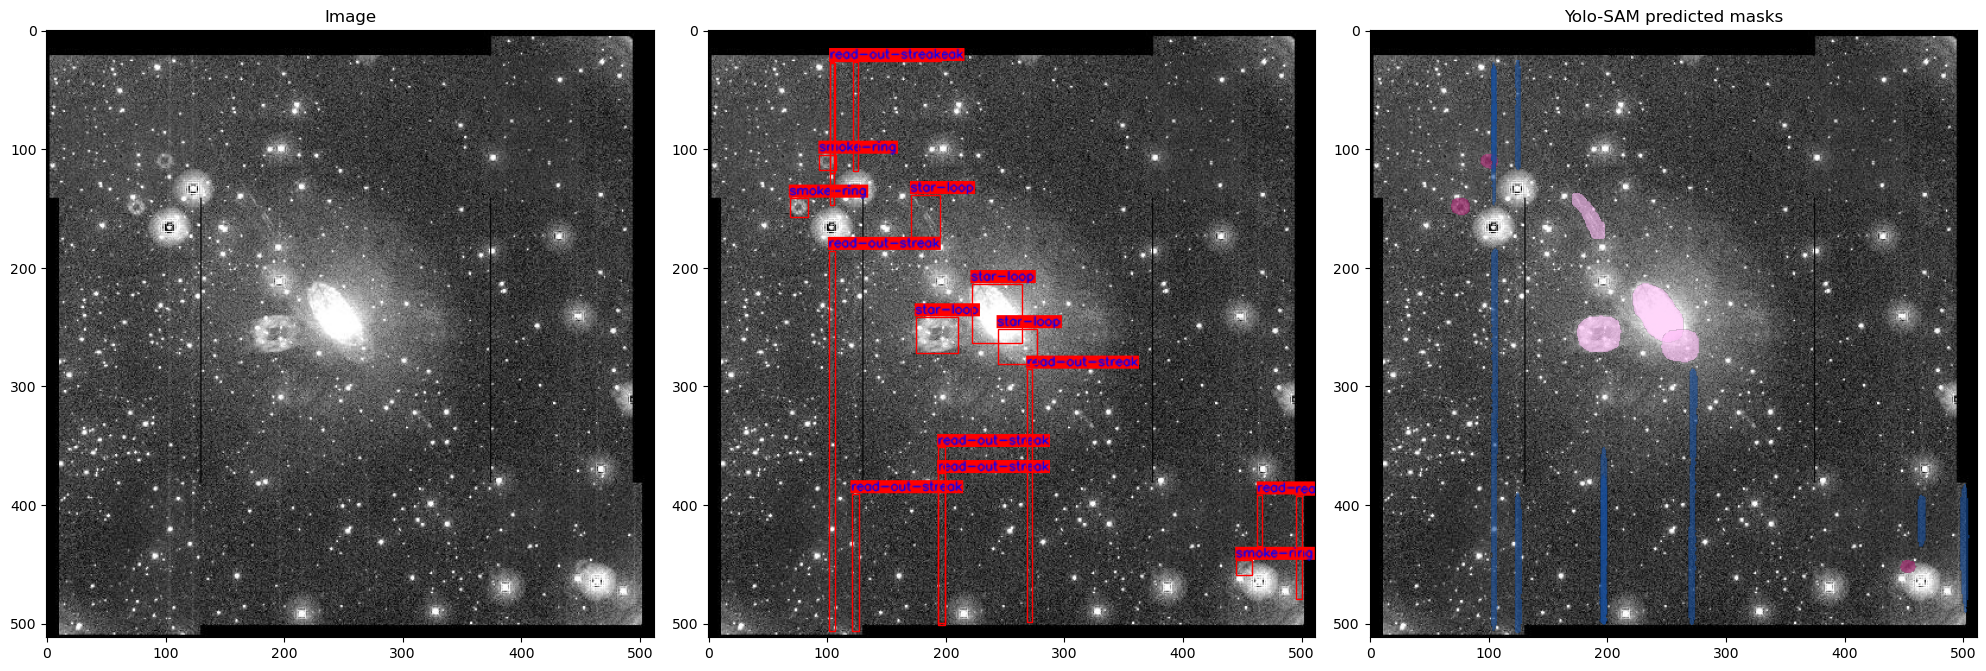

In [3]:
# masks = yolo_sam_pipeline.run_predict('../XAMI-dataset/xami_dataset/valid/S0743200101_V_png.rf.dba4ec263252737ec92121f599a4ca8b.jpg', show_masks=True)
masks = yolo_sam_pipeline.run_predict('./example_images/S0743200101_V.jpg', show_masks=True) 

**Inference on images from XMM Optical Monitor not used in our dataset.**

Number of object detected: 2
   central-ring
   star-loop


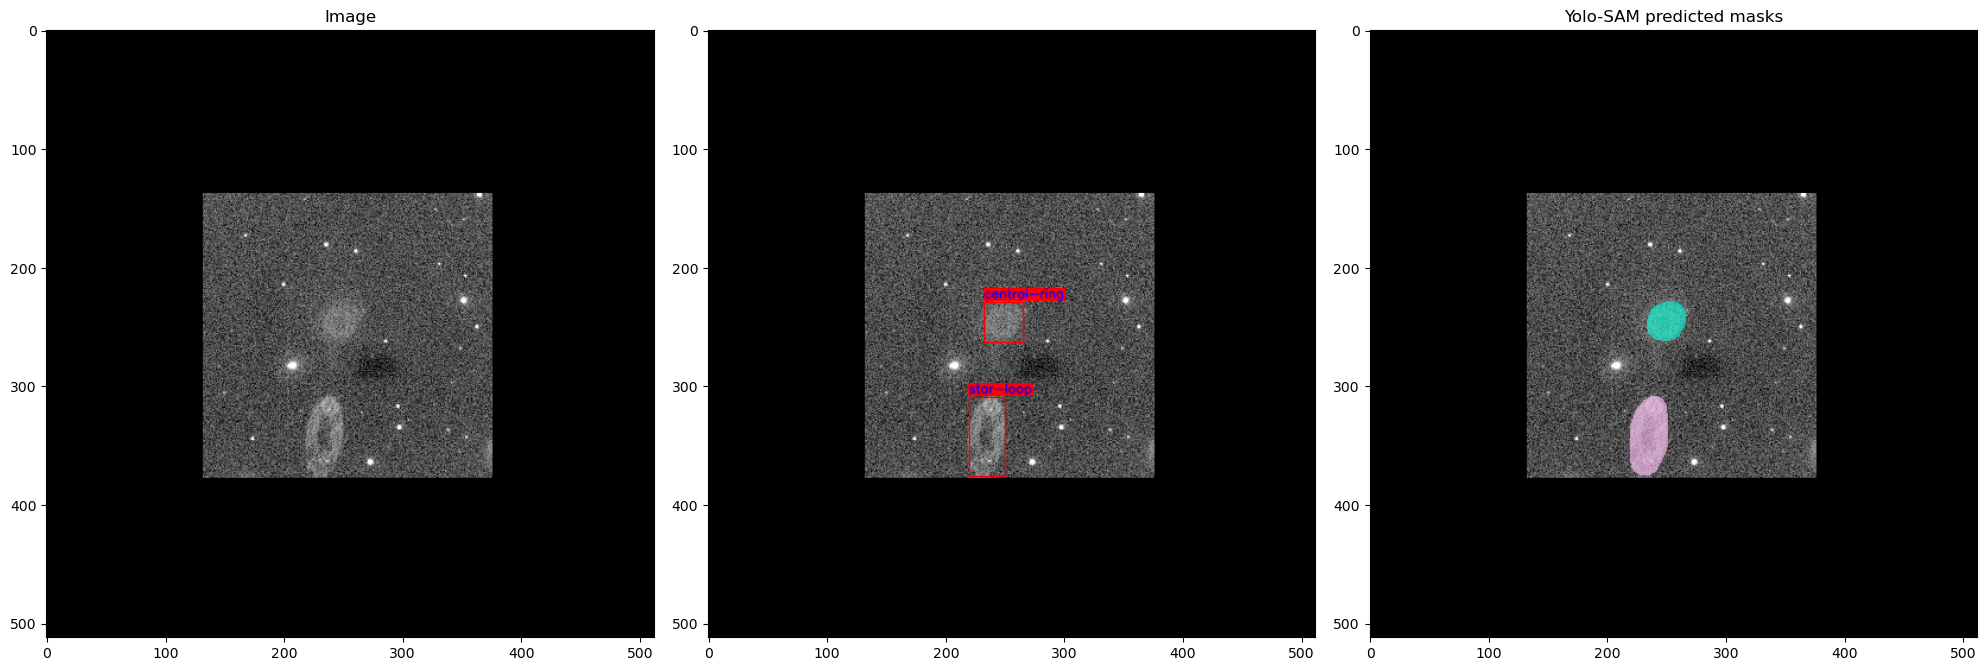

In [4]:
masks = yolo_sam_pipeline.run_predict('./example_images/S0893811101_M.png', show_masks=True) 